![alt text](entry.png "Title")

In [1]:
from vrp_viz import VRPPlot
from ortools.constraint_solver import routing_enums_pb2, pywrapcp
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import pandas as pd
import time
import matplotlib.pyplot as plt
import random
import yaml
import csv

In [2]:
app = Nominatim(user_agent="JournalDev")

In [3]:
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}')
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            plan_output += ' {0} Load({1}) -> '.format(node_index, route_load)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += ' {0} Load({1})\n'.format(manager.IndexToNode(index),
                                                 route_load)
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        plan_output += 'Load of the route: {}\n'.format(route_load)
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    print('Total distance of all routes: {}m'.format(total_distance))
    print('Total load of all routes: {}'.format(total_load))

In [4]:
def perform_TSP(data, manager, routing):
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)


    # Add Capacity constraint.
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(
        demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    search_parameters.time_limit.FromSeconds(1)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)


    # Return solution or print solution on console
    if solution:
        return solution

In [5]:
def distance_between_two_nodes(start, end):
    return int(1000*(geodesic(start, end).km))

In [6]:
def read_yaml_file(yaml_file):
    with open(yaml_file, 'r', encoding="utf8") as file:
        data = yaml.load(file, Loader=yaml.FullLoader)
        
    return data

In [7]:
def find_n_points(n):
    data = read_yaml_file('Data//data.yaml')
    points = []
    visited = []
    while len(points) < n:
        i = random.randint(0, len(data))
        while i in visited:
            i = random.randint(0, len(data))
        try:
            time.sleep(1)
            location = app.geocode(data[i]).raw
            points.append([float(location['lat']), float(location['lon'])])
            visited.append(i)
        except:
            pass
 
    return points

# Punkty z Wrocławia - losowe

In [8]:
N = 175  # liczba punktów

In [9]:
adresses = find_n_points(N)

In [10]:
def _create_data_model(distances, num_vehicles=None):
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = distances
    data['num_vehicles'] = 1 if num_vehicles == None else num_vehicles
    data['depot'] = 0  
    data['demands'] = [0] + [1]*95 + [2]*45 + [3]*25 + [4]*10
    data['vehicle_capacities'] =[60]*5
    return data

In [11]:
distances = [[distance_between_two_nodes(a, b) for a in adresses]
                          for b in adresses]

num_vehicles = 5

data = _create_data_model(distances=distances, num_vehicles=num_vehicles)

# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                       data['num_vehicles'], data['depot'])

# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)

solution = perform_TSP(data=data, manager=manager, routing=routing)

In [12]:
print_solution(data=data, manager=manager, routing=routing, solution=solution)

Objective: 204067
Route for vehicle 0:
 0 Load(0) ->  134 Load(2) ->  26 Load(3) ->  22 Load(4) ->  3 Load(5) ->  35 Load(6) ->  102 Load(8) ->  138 Load(10) ->  77 Load(11) ->  116 Load(13) ->  136 Load(15) ->  72 Load(16) ->  103 Load(18) ->  37 Load(19) ->  57 Load(20) ->  31 Load(21) ->  91 Load(22) ->  143 Load(25) ->  153 Load(28) ->  9 Load(29) ->  168 Load(33) ->  46 Load(34) ->  156 Load(37) ->  117 Load(39) ->  141 Load(42) ->  1 Load(43) ->  137 Load(45) ->  110 Load(47) ->  132 Load(49) ->  151 Load(52) ->  70 Load(53) ->  75 Load(54) ->  23 Load(55) ->  80 Load(56) ->  83 Load(57) ->  154 Load(60) ->  0 Load(60)
Distance of the route: 41237m
Load of the route: 60

Route for vehicle 1:
 0 Load(0) ->  150 Load(3) ->  92 Load(4) ->  149 Load(7) ->  121 Load(9) ->  106 Load(11) ->  135 Load(13) ->  155 Load(16) ->  45 Load(17) ->  159 Load(20) ->  27 Load(21) ->  2 Load(22) ->  67 Load(23) ->  165 Load(26) ->  100 Load(28) ->  36 Load(29) ->  24 Load(30) ->  129 Load(32) ->  1

In [13]:
def return_solution(data, manager, routing, solution):
    index = routing.Start(0)
    output = []
    distances = []
    distances_2 = []
    total_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        single_output = []
        index = routing.Start(vehicle_id)
        route_distance = 0
        route_distance_2 = 0
        while not routing.IsEnd(index):
            single_output.append(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            #print(previous_index, index)
            try:
                route_distance += distance_between_two_nodes(adresses[previous_index], adresses[index])
            except:
                route_distance += distance_between_two_nodes(adresses[0], adresses[0])
                
            route_distance_2 += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
            
        single_output.append(0)
        output.append(single_output)
        distances_2.append(f'{round(int(route_distance_2)/1000, 2)} km')
        distances.append(f'{round(int(route_distance)/1000, 2)} km')
        total_distance += round(int(route_distance)/1000, 2)
    return output, distances, total_distance, distances_2

In [14]:
routes, distances, total_distance, distances_2 = return_solution(data=data, manager=manager, routing=routing, solution=solution)

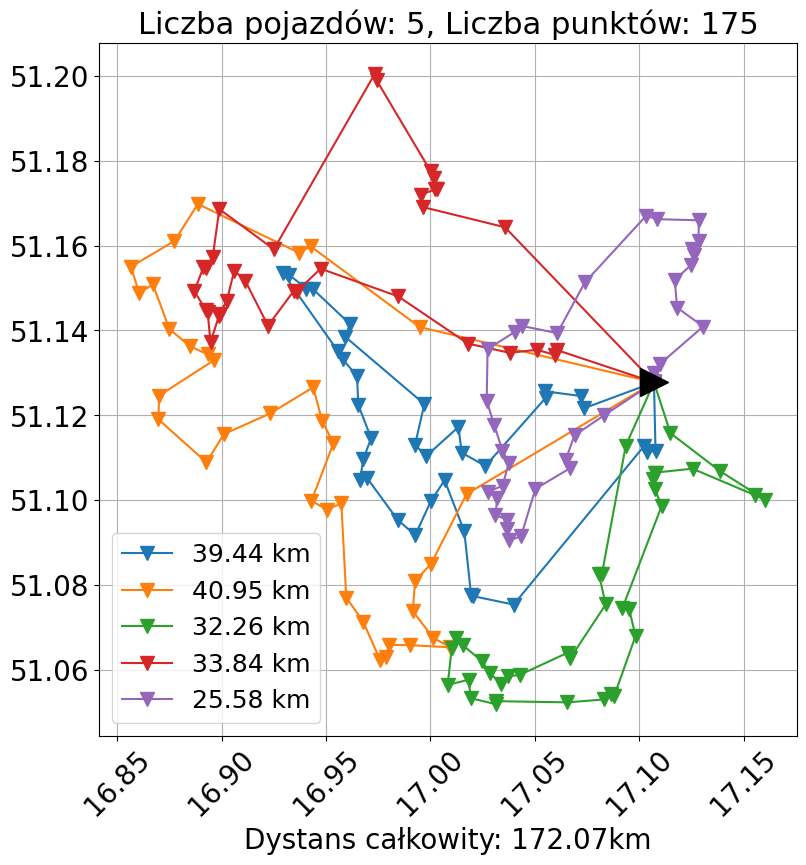

In [15]:
plt.figure(figsize=(9, 9))
for route in routes:
    coords_route_x = [adresses[node][0] for node in route]
    coords_route_y = [adresses[node][1] for node in route]
    plt.plot(coords_route_y, coords_route_x, 'v-', markersize=10)
plt.plot(coords_route_y[0], coords_route_x[0], '>', color='black', markersize=20)
plt.legend(distances, prop={'size': 18})
plt.title(f'Liczba pojazdów: {num_vehicles}, Liczba punktów: {len(adresses)}', fontsize=22)
plt.yticks(fontsize=20)
plt.xlabel(f'Dystans całkowity: {round(total_distance, 2)}km', fontsize=20)
plt.xticks(fontsize=20, rotation=45)
plt.grid()

In [16]:
VRPPlot(coords=adresses, trails=routes, one_way=False).show()

# Save the same points

In [38]:
with open('addresses.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(adresses)

# Saved points from Wroclaw

In [50]:
adresses = []
with open('addresses.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        if row != []:
            adresses.append([float(row[0]), float(row[1])])

In [52]:
distances = [[distance_between_two_nodes(a, b) for a in adresses]
                          for b in adresses]

num_vehicles = 5

data = _create_data_model(distances=distances, num_vehicles=num_vehicles)

# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                       data['num_vehicles'], data['depot'])

# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)

solution = perform_TSP(data=data, manager=manager, routing=routing)

In [53]:
print_solution(data=data, manager=manager, routing=routing, solution=solution)

Objective: 204067
Route for vehicle 0:
 0 Load(0) ->  134 Load(2) ->  26 Load(3) ->  22 Load(4) ->  3 Load(5) ->  35 Load(6) ->  102 Load(8) ->  138 Load(10) ->  77 Load(11) ->  116 Load(13) ->  136 Load(15) ->  72 Load(16) ->  103 Load(18) ->  37 Load(19) ->  57 Load(20) ->  31 Load(21) ->  91 Load(22) ->  143 Load(25) ->  153 Load(28) ->  9 Load(29) ->  168 Load(33) ->  46 Load(34) ->  156 Load(37) ->  117 Load(39) ->  141 Load(42) ->  1 Load(43) ->  137 Load(45) ->  110 Load(47) ->  132 Load(49) ->  151 Load(52) ->  70 Load(53) ->  75 Load(54) ->  23 Load(55) ->  80 Load(56) ->  83 Load(57) ->  154 Load(60) ->  0 Load(60)
Distance of the route: 41237m
Load of the route: 60

Route for vehicle 1:
 0 Load(0) ->  150 Load(3) ->  92 Load(4) ->  149 Load(7) ->  121 Load(9) ->  106 Load(11) ->  135 Load(13) ->  155 Load(16) ->  45 Load(17) ->  159 Load(20) ->  27 Load(21) ->  2 Load(22) ->  67 Load(23) ->  165 Load(26) ->  100 Load(28) ->  36 Load(29) ->  24 Load(30) ->  129 Load(32) ->  1

In [54]:
routes, distances, total_distance, distances_2 = return_solution(data=data, manager=manager, routing=routing, solution=solution)

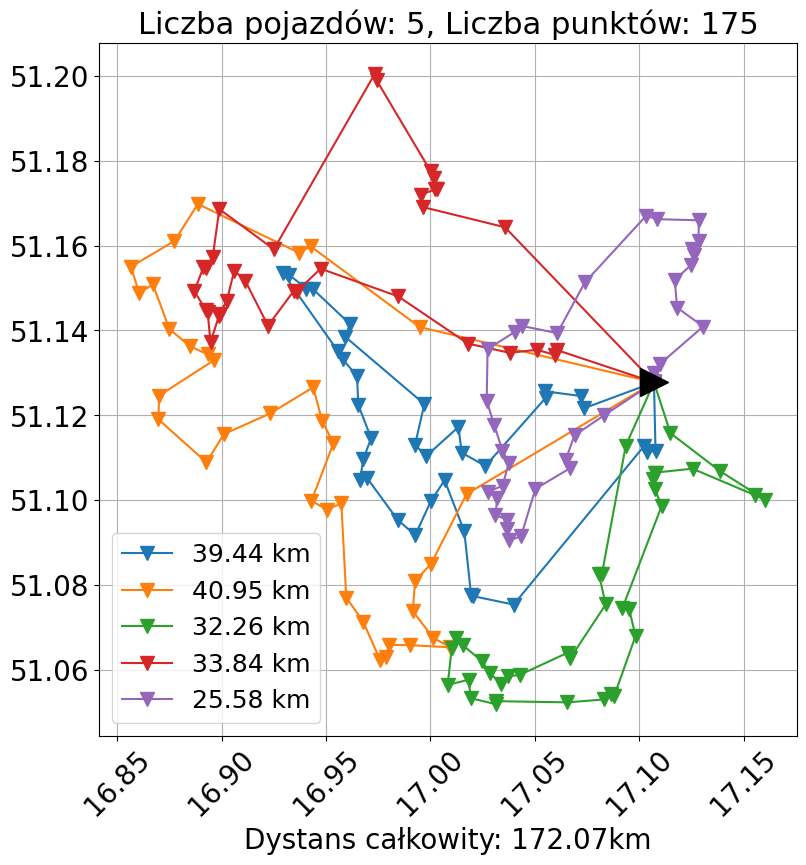

In [55]:
plt.figure(figsize=(9, 9))
for route in routes:
    coords_route_x = [adresses[node][0] for node in route]
    coords_route_y = [adresses[node][1] for node in route]
    plt.plot(coords_route_y, coords_route_x, 'v-', markersize=10)
plt.plot(coords_route_y[0], coords_route_x[0], '>', color='black', markersize=20)
plt.legend(distances, prop={'size': 18})
plt.title(f'Liczba pojazdów: {num_vehicles}, Liczba punktów: {len(adresses)}', fontsize=22)
plt.yticks(fontsize=20)
plt.xlabel(f'Dystans całkowity: {round(total_distance, 2)}km', fontsize=20)
plt.xticks(fontsize=20, rotation=45)
plt.grid()

In [56]:
VRPPlot(coords=adresses, trails=routes, one_way=False).show()